# Vector vs raster

### 01_01 Vector vs raster:

As introduced earlier, in this section, we are going to work with two different data sets with a special spatial focus on Germany. 

The first data set we are going to use is a Germany-level elevation raster. You might have seen this raster data set in my previous, introductory-level course, Geospatial Raster Data Analytics in Python, as well.

The second data source is a Europe-wide vector data set containing large administrative units coming from the Nomenclature of Territorial Units for Statistics - shortly, NUTS. 

In this section, after a short data exploration, we are going to learn how to convert between these data files and formats - how to turn vector data into raster and raster data into vector. While, as you will see, there are some ready-made tools to cover some parts of this conversion as well, by doing it from scratch, we are going to gain much deeper technical insights on how to take spatial data apart and piece it together. 

This experience will equip you with all the necessary skills to analyze spatial data at an advanced level.



To start this journey, let's import all the necessary libraries and functions as follows
- We will need numpy, matplotlib, and math from the standard Python packages to do data manipulation and visualization
- We will need GeoPandas and a few functions from shapely to handle vector data
- We will need to import rasterio and a couple of its functions to handle raster data



In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, box

import rasterio
from rasterio.plot import show
from rasterio.transform import xy, from_origin
from rasterio.features import rasterize
from rasterstats import zonal_stats

import warnings
warnings.filterwarnings('ignore')

### 01_02 Data description - raster data

First, let's read and explore the input raster data. Remember, this raster grid contains elevation values all across Germany.

After naming the raster file  *srtm_germany_dsm.tif*, we use the open function of rasterio and load the grid data into a variable called *raster*

In [2]:
raster_file = "srtm_germany_dsm.tif"

with rasterio.open(raster_file) as src:
    # 1-band DEM, mask out nodata for clean stats/plotting
    raster = src.read(1, masked=True)

Then let's extend this reader code by a few more details - which will tell us what exactly is stored in this raster grid.

The parameters we will query and print are the CRS and the spatial resolution of the raster grid, the size and shape of the raster, and the characteristic elevation values it stores.

In [3]:
with rasterio.open(raster_file) as src:
    # 1-band DEM, mask out nodata for clean stats/plotting
    raster = src.read(1, masked=True)
    
    # --- quick “characterization” -------------------------------------------
    print("⛰  DEM summary")
    print(f"  • CRS        : {src.crs}")
    print(f"  • Resolution : {src.res[0]} × {src.res[1]} {src.units[0]}")
    print(f"  • Shape      : {raster.shape} (rows, cols)")
    print(f"  • Number of pixels      : {raster.shape[0] * raster.shape[1] / 1000000} megapixels")    
    print(
        f"  • Elevation  : min={raster.min():.1f} m  "
        f"mean={raster.mean():.1f} m  max={raster.max():.1f} m"
    )



⛰  DEM summary
  • CRS        : EPSG:4326
  • Resolution : 0.0008333333333333333 × 0.0008333333333333333 None
  • Shape      : (10801, 13201) (rows, cols)
  • Number of pixels      : 142.584001 megapixels
  • Elevation  : min=0.0 m  mean=264.6 m  max=3730.0 m


As you can see in the cell output, the grid comes in EPSG:4326 CRS. 

The spatial resolution is 0.0008333. However, the printed unit of measure appears to be missing signaled by the None value. Nevertheless, after doing some reading on the data set, it becomes clear that its nominal resolution is 100 meters, while the 3 arc-seconds (3″) in both latitude and longitude is approximately equivalent to 92.6 m - which means that the 0.0008333 should be in degrees.

Then, we can also see that the raster image is more than 10,000 pixels in each direction, resulting in a final grid data of 142 megapixels.

Additionally, from this output we can also tell that the elevation starts at 0 level, has a mean value of 264.6m, and the highest peak goes  up to 3730 m.

Now let's have a quick visual look and plot the raster grid as well. As we did in the introducotry course, here again we will use an appropriate terrain colormap in Matplotlib.

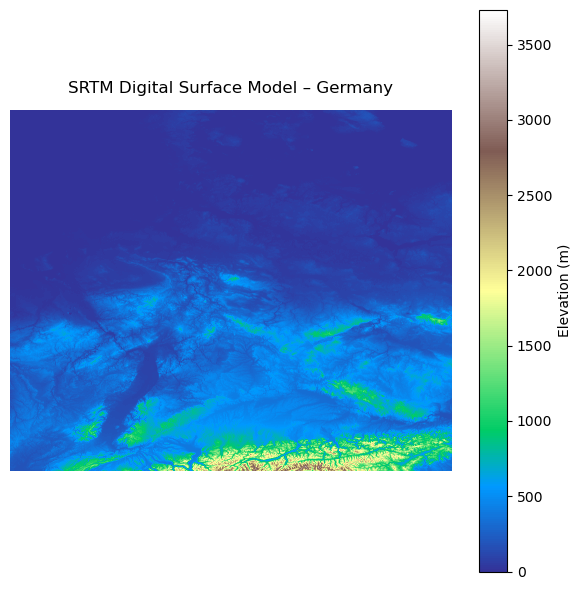

In [4]:

with rasterio.open(raster_file) as src:
    # 1-band DEM, mask out nodata for clean stats/plotting
    raster = src.read(1, masked=True)



    # --- visualisation -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 6))
    # DEM
    im = ax.imshow(
        raster,
        cmap="terrain",
        vmin=raster.min(),
        vmax=raster.max(),
    )
    # national outline for context (Natural Earth sample
    ax.set_title("SRTM Digital Surface Model – Germany", pad=12)
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax, label="Elevation (m)")
    plt.tight_layout()
    plt.show()


### 01_03 Data description - vector data

Now let's move on to the vector data set containing administrative areas across Europe.

First, let's read in the file and then print the unique values of the *CNTR_CODE* column. This exercise will tell us the short codes of all  countries present in the data set - and from which we will need to filter out Germany.

In [5]:
gdf_nuts1 = gpd.read_file("NUTS 1 - 2016")  # folder / shapefile, GeoPackage, etc.
set(gdf_nuts1.CNTR_CODE)

{'AL',
 'AT',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LI',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR',
 'UK'}

Let's use the country code 'DE' to filter Germany out:

In [6]:
gdf_nuts1 = gdf_nuts1[gdf_nuts1.CNTR_CODE=='DE']
print(len(gdf_nuts1))
gdf_nuts1.head(3)

16


,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
2,1,DE1,DE,BADEN-WÃRTTEMBERG,0,0,0,DE1,"MULTIPOLYGON (((10.08372 49.54356, 10.08747 49..."
4,1,DEA,DE,NORDRHEIN-WESTFALEN,0,0,0,DEA,"POLYGON ((8.70301 52.50044, 8.69906 52.4869, 8..."
6,1,DE7,DE,HESSEN,0,0,0,DE7,"MULTIPOLYGON (((9.68533 51.58202, 9.69019 51.5..."


As it seems, in Germany, there are 16 NUTS1 regions total.

Now let's see the basic properties of the grid, such as its CRS:

In [7]:
# --- quick “characterization” ----------------------------------------------
print("🗺  NUTS-1 layer summary")
print(f"  • CRS            : {gdf_nuts1.crs}")
print(f"  • Record count  : {len(gdf_nuts1)}")
print(f"  • Extent (xmin, ymin, xmax, ymax): {gdf_nuts1.total_bounds.round(3)}")
print(f"  • Attribute cols : {list(gdf_nuts1.columns)}")

🗺  NUTS-1 layer summary
  • CRS            : EPSG:4326
  • Record count  : 16
  • Extent (xmin, ymin, xmax, ymax): [ 5.868 47.27  15.041 55.058]
  • Attribute cols : ['LEVL_CODE', 'NUTS_ID', 'CNTR_CODE', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'FID', 'geometry']


We can confirm that this data set in in epsg:4326 as well. Now let's also have a quick look at it using Matplotlib.

In this plot we will adjust the colormap, the edgecolor, the opacity, and the legend formatting of the plot as well.

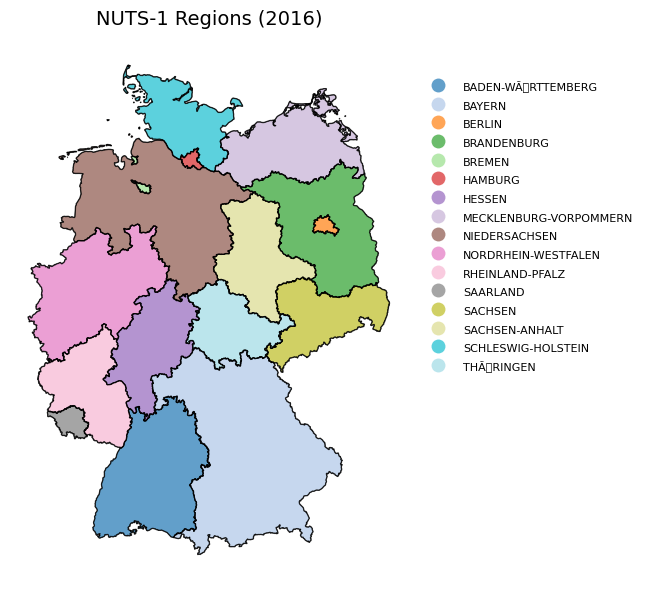

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

# boundaries first for neat black outlines
gdf_nuts1.boundary.plot(ax=ax, linewidth=0.4, edgecolor="black")

# fill polygons, coloured by region name
legend = gdf_nuts1.plot(
    ax=ax,
    column="NUTS_NAME",
    categorical=True,
    legend=True,
    alpha=0.7,
    cmap="tab20",
    edgecolor="black",
).get_legend()            # grab the Legend object

# --- adjust legend ----------------------------------------------------------
legend.set_bbox_to_anchor((1.6, 0.95), transform=ax.transAxes)  # to the right, centred
legend.set_frame_on(False)                                        # keep the white box
for txt in legend.get_texts():                                   # shrink label font
    txt.set_fontsize(8)

# --- finishing touches ------------------------------------------------------
ax.set_title("NUTS-1 Regions (2016)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


### 01_04 The basics - zonal statistics


We have already covered one way of combining vector and raster data in the introductory course - now let's quickly review it: zonal statistics.

Zonal statistics, using the built-in function of rasterio, is a quick, easy, and computationally optimized way to match vector and raster data.

This is great if we want to do some quick off-the-shelf statistics over raster data.

However, this solution lacks flexibility in terms of slicing our data sets into smaller parts and then piecing them together to fit any possible use case. While we will cover these possibilities later, now let's have a quick look at zonal statistics and, as a reference computation, measure the average elevation level within each NUTS area of Germany.


For this, we only need to use a simple function call of the rasterio function called zonal_stats - and we have the zonal statistics ready to go. Regarding this function, 
- we just need to add the GeoDataFrame containing the polygon zones we would like to compute the statistics over
- the raster file's path
- the kind of statistics we would like to compute - in this case, mean, but we can add others such as median are possible as well

In [9]:
stats = zonal_stats(
    vectors=gdf_nuts1,          
    raster=raster_file,
    stats=["mean", "median"],

)

stats

[{'mean': 493.03825007948745, 'median': 483.0},
 {'mean': 174.6851549670616, 'median': 102.0},
 {'mean': 303.34303060094965, 'median': 302.0},
 {'mean': 63.679135803256116, 'median': 58.0},
 {'mean': 323.60846762362763, 'median': 325.0},
 {'mean': 21.005300606757558, 'median': 17.0},
 {'mean': 310.1817627046242, 'median': 302.0},
 {'mean': 117.59056120045705, 'median': 85.0},
 {'mean': 292.63303719107154, 'median': 240.0},
 {'mean': 363.1489147593136, 'median': 338.0},
 {'mean': 513.5006320199675, 'median': 472.0},
 {'mean': 44.541099634944246, 'median': 44.0},
 {'mean': 38.34438763113228, 'median': 35.0},
 {'mean': 4.713462532936049, 'median': 3.0},
 {'mean': 15.825259962979095, 'median': 12.0},
 {'mean': 69.71747845251902, 'median': 41.0}]

As you can see, the result of this call is a list of dictionaries with the computed metrics, which we can easily map back to the vector data frame:

In [10]:
gdf_nuts1["mean_elev_m"] = [s["mean"] for s in stats]
gdf_nuts1.head(3)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,mean_elev_m
2,1,DE1,DE,BADEN-WÃRTTEMBERG,0,0,0,DE1,"MULTIPOLYGON (((10.08372 49.54356, 10.08747 49...",493.038250
4,1,DEA,DE,NORDRHEIN-WESTFALEN,0,0,0,DEA,"POLYGON ((8.70301 52.50044, 8.69906 52.4869, 8...",174.685155
6,1,DE7,DE,HESSEN,0,0,0,DE7,"MULTIPOLYGON (((9.68533 51.58202, 9.69019 51.5...",303.343031


In some cases, we might need to align the crs of the two data sets as follows - however, since we already confirmed both are in epsg:4326, I didnt include this step in the previous code block:

In [11]:
with rasterio.open(raster_file) as src:
    raster_crs   = src.crs                     

gdf_nuts1 = gdf_nuts1.to_crs(raster_crs)

Finally, let's visualize the elevation-extended nuts geodataframe usign the usual matplotlib tools.

We will add the boundary lines of the polygons with  black lines, use the terrain colormap, and add a colorbar and image titles as well.

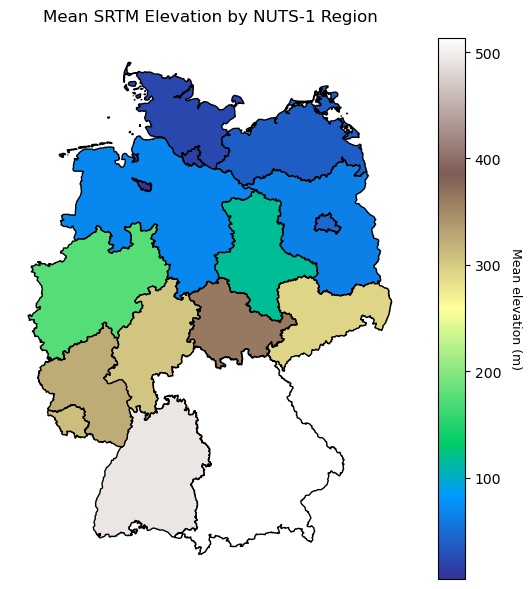

In [12]:

fig, ax = plt.subplots(figsize=(6, 6))


gdf_nuts1.plot(
    ax=ax,
    column="mean_elev_m",
    cmap="terrain",
    legend=True,            # GeoPandas creates the colour-bar for us
    edgecolor="black",
)

# ── give the colour-bar a title / label ───────────────────────────────────
cbar_ax = fig.axes[-1]      # the colour-bar is the last axis in the figure
cbar_ax.set_ylabel("Mean elevation (m)", rotation=270, labelpad=15, fontsize=9)

# map title & layout
ax.set_title("Mean SRTM Elevation by NUTS-1 Region", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


### 01_05 Turning the raster data into vector grid

While the zonal statistics provide an easy way to map a raster grid into a vector data layer, now we will learn an atomized method to transform any raster grid into its vector counterpart without the need for aggregation and the potential of information loss.

However, since our original raster data contains nearly 150 million pixels (142,584,001), or data points, to make the following computations more manageable, first let's downsample it.

First,we define a sample fraction, an integer number, which will roughly determine what percentage of the original grid data we will keep. Since the data set is two-dimensional, while we define this ratio number in one dimension, we will need to do a little math. Also, this formula has to respect the fact that we need ian nteger number of pixels in both dimensions:

In [13]:
raster_file = "srtm_germany_dsm.tif"
sample_fraction = 0.9 # 0.01 %

In [14]:
# ── derive an integer stride so that stride² ≈ 1/sample_fraction ─────────────
stride = max(1, int(round(math.sqrt(1 / (sample_fraction/100) ))))   # 1 % ➜ stride = 10

print(stride)

11


Now  let's move on and read in the raster file.

For this, we will need to zero out the entire raster grid except every 32nd pixel in both the x and y directions.

Let's do that, and then print the number of pixels before and after the subsampling. 

In [15]:
with rasterio.open(raster_file) as src:
    raster = src.read(1, masked=True)
    transform = src.transform

    # --- build mask of valid data pixels -------------------------------
    mask = np.ma.getmaskarray(raster)
    valid_mask = ~mask
    valid_pix = valid_mask.sum()
    print("⛰  Down-sampling summary")
    print(f"  • Stride                  : {stride}")
    print(f"  • Total valid pixels      : {valid_pix:,}")

    # --- candidate pixel indices before subsampling --------------------
    rows_sub, cols_sub = np.where(valid_mask)
    print(f"  • Candidates before subsample : {len(rows_sub):,}")


    # --- apply stride constraint --------------------------------------
    keep = (rows_sub % stride == 0) & (cols_sub % stride == 0)
    rows, cols = rows_sub[keep], cols_sub[keep]
    kept = len(rows)
    ratio = kept / valid_pix
    print(f"  • Kept after subsample        : {kept:,}  ({ratio:.2%} of valid pixels)")

    

⛰  Down-sampling summary
  • Stride                  : 11
  • Total valid pixels      : 142,584,001
  • Candidates before subsample : 142,584,001
  • Kept after subsample        : 1,179,382  (0.83% of valid pixels)


Now that we have a proven method for subsampling, let's get back into that piece of code and extend it.

This extension will extract the row and column indices of each pixel that was kept after the filtering.

In other words, it will be able to work with the coordinates if each sampled pixel, which, when we apply the right crs, will turn into the sampled set of geospatial data.


Then, once we have the rows and columns, each containing the coordinates, we just need to write a Python loop and call the GeoDataFrame constructor to turn these into a GeoDataFrame.

In this GeoDataFrame, each record contains a point geometry, each corresponding to one of the sampled pixels and has the value of elevation. To ensure we have the right projection system, just use the one extracted from the source raster grid - src.crs. 

In [16]:
with rasterio.open(raster_file) as src:
    raster = src.read(1, masked=True)
    transform = src.transform

    # --- build mask of valid data pixels -------------------------------
    mask = np.ma.getmaskarray(raster)
    valid_mask = ~mask
    
    # --- candidate pixel indices before subsampling --------------------
    rows_sub, cols_sub = np.where(valid_mask)
    print(f"  • Candidates before subsample : {len(rows_sub):,}")

    # --- apply stride constraint ---------------------------------------
    keep = (rows_sub % stride == 0) & (cols_sub % stride == 0)
    rows, cols = rows_sub[keep], cols_sub[keep]
   
    # --- build GeoDataFrame of sampled centroids ----------------------
    xs, ys = xy(transform, rows, cols, offset="center")

    gdf_grid = gpd.GeoDataFrame(
        {"elev_m": raster.data[rows, cols].astype(float)},
        geometry=[Point(x, y) for x, y in zip(xs, ys)],
        crs=src.crs,
    )
    print(f"  • Rows in GeoDataFrame        : {len(gdf_grid):,}")

  • Candidates before subsample : 142,584,001
  • Rows in GeoDataFrame        : 1,179,382


In [17]:
gdf_grid.head()

,elev_m,geometry
0,0.0,POINT (5 56)
1,0.0,POINT (5.00917 56)
2,0.0,POINT (5.01833 56)
3,0.0,POINT (5.0275 56)
4,0.0,POINT (5.03667 56)


For later use, let's save the elevation point grid data:

In [18]:
gdf_grid.to_file('Germany_elevation_grid.geojson', driver = 'GeoJSON')

Finally, let's plot the results using the usual matplotlib plotting style.

Now we should also add boundary lines using the original nuts dataset. 

What you will spot immediately is that we don't have continuous coloring - that's simply because now each data point visualized is a point.

Here, I recommend experimenting a bit with the sampling ratio. If you choose a large enough value, the individual points shown on this visual will overlap so much that the image will seem to be continuous. 

Let's see it how!

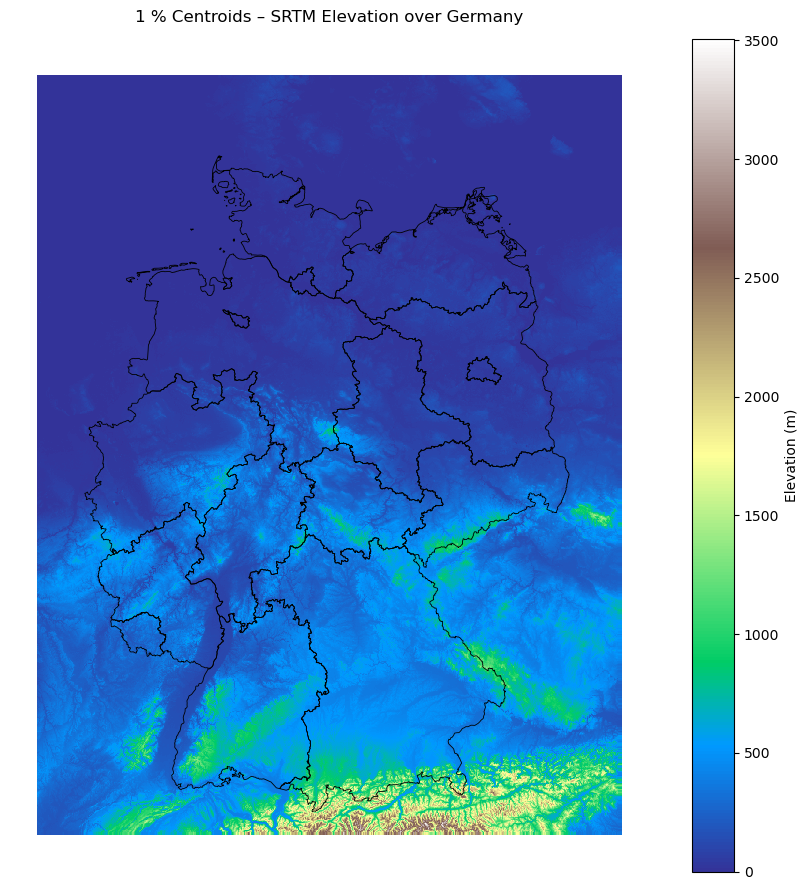

In [19]:
# ── plot ─────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 9))

# 1) Germany outline for context
gdf_nuts1.boundary.plot(ax=ax, linewidth=0.6, edgecolor="black")

# 2) Centroid sample, coloured by elevation (terrain colormap)
sc = ax.scatter(
    gdf_grid.geometry.x,
    gdf_grid.geometry.y,
    s=6,                          # marker size
    c=gdf_grid["elev_m"],         # use the down-sampled elev values
    cmap="terrain",
    marker="s",                   # little squares to line up on raster grid
    linewidth=0,
)

# 3) Layout tweaks
cbar = plt.colorbar(sc, ax=ax, label="Elevation (m)")
ax.set_title("1 % Centroids – SRTM Elevation over Germany", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


This way, we learned how to turn a large raster grid into a significantly smaller vector dataset containing nearly the same information.

Such steps can be very useful when we need to merge large raster files with vector data, when we would like to feed point-level information into machine learning models, or just create quick, lightweight, and easy-to-customize visuals.

Of course, on this data set we can easily create geospatial overlays and spatial joins, which will end up in similar results as if we were computing zonal statistics - however, now done from scratch, with complete control over the process.
  

### 01_06 Rasterizing vector data


After turning raster data into vector data, we will sort of do it in reverse.

We will learn how we can transform a vector data layer into a grid.

In this exercise, we will turn the Germany-level NUTS1 polygons into a grid where each pixel has a size of 25x25km. For this we will use the local crs EPSG:25832.


First, we need to make convert the GeoDataFrame into the local CRS and define the pixel size in meters.

In [20]:
target_epsg = 25832
gdf_nuts1_local = gdf_nuts1.to_crs(target_epsg)
pixel_size = 25000

Then, we extract the bounding box of the vector data set and do a few lines of simple calculations to come up with the number of pixels in each direction:

In [21]:
# derive grid origin, dimensions & transform
xmin, ymin, xmax, ymax = gdf_nuts1_local.total_bounds

# align to the pixel_size so grid snaps to your mesh
xmin = math.floor(xmin / pixel_size) * pixel_size
ymin = math.floor(ymin / pixel_size) * pixel_size
xmax = math.ceil(xmax / pixel_size) * pixel_size
ymax = math.ceil(ymax / pixel_size) * pixel_size

n_pixels_x = int((xmax - xmin) / pixel_size)
n_pixels_y = int((ymax - ymin) / pixel_size)


Then, we use the extracted lower and upper bounds of the vector data set as well as teh computed pixel size to create the list of pixels.

Each pixel will be a small box which we can easily create with shapely by definnig the bottom left and top right corners of each pixel. 

Let's see how this works in practice with a simple for loop and the GeoDataFrame constructor:

In [22]:
# 3. build the vector grid
xs = np.arange(xmin, xmax, pixel_size)
ys = np.arange(ymin, ymax, pixel_size)

# create one square polygon per cell
nuts_grid_polys = [
    box(x, y, x + pixel_size, y + pixel_size)
    for y in ys
    for x in xs
]

nuts_grid = gpd.GeoDataFrame(geometry=nuts_grid_polys, crs=f"EPSG:{target_epsg}")
nuts_grid.head()

,geometry
0,"POLYGON ((300000 5225000, 300000 5250000, 2750..."
1,"POLYGON ((325000 5225000, 325000 5250000, 3000..."
2,"POLYGON ((350000 5225000, 350000 5250000, 3250..."
3,"POLYGON ((375000 5225000, 375000 5250000, 3500..."
4,"POLYGON ((400000 5225000, 400000 5250000, 3750..."


Now let's make sure each box also inherits some of the original properties, namely, the NUTS_NAME of each area:

In [23]:
# spatial join to burn in the value_col
nuts_grid = gpd.sjoin(
    nuts_grid,
    gdf_nuts1_local[["NUTS_NAME", "geometry"]],
    how="left",
    predicate="intersects",
).drop(columns="index_right")

# fill cells with no intersection
nuts_grid["NUTS_NAME"] = nuts_grid["NUTS_NAME"].fillna(np.nan)
nuts_grid.head()

,geometry,NUTS_NAME
0,"POLYGON ((300000 5225000, 300000 5250000, 2750...",NaN
1,"POLYGON ((325000 5225000, 325000 5250000, 3000...",NaN
2,"POLYGON ((350000 5225000, 350000 5250000, 3250...",NaN
3,"POLYGON ((375000 5225000, 375000 5250000, 3500...",NaN
4,"POLYGON ((400000 5225000, 400000 5250000, 3750...",NaN


At this point we still have a vector data - let's have a look using the usual matplotlib tools.

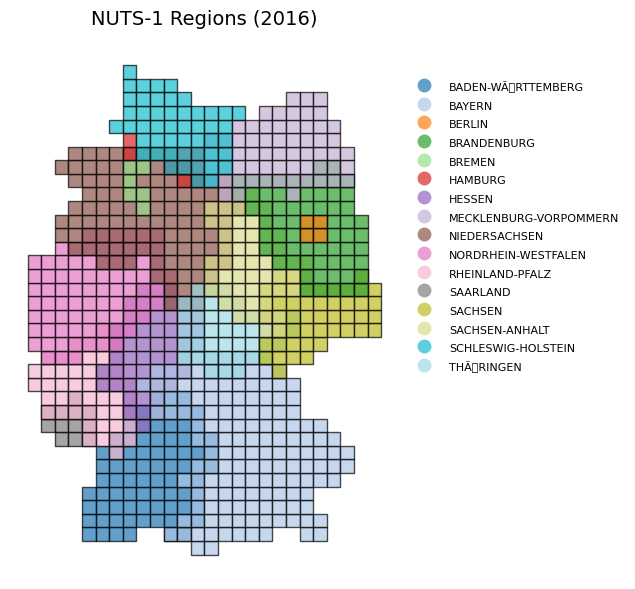

In [24]:
# --- visualisation ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# boundaries first for neat black outlines
legend = nuts_grid.plot(
    ax=ax,
    column="NUTS_NAME",
    categorical=True,
    legend=True,
    alpha=0.7,
    cmap = 'tab20',
    edgecolor="black").get_legend()            # grab the Legend object

# --- adjust legend ----------------------------------------------------------
legend.set_bbox_to_anchor((1.6, 0.95), transform=ax.transAxes)  # to the right, centred
legend.set_frame_on(False)                                        # keep the white box
for txt in legend.get_texts():                                   # shrink label font
    txt.set_fontsize(8)

# --- finishing touches ------------------------------------------------------
ax.set_title("NUTS-1 Regions (2016)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


As you can see here on this figure, now each NUTS polygon is replaced by a set of 25x25km grids, each colored based on the name of the NUTS region.

There is only one step left - turn this into a raster file using the geotiff file format. 

Fortunately, we can quickly use the rasterize function of rasterio to turn the vector grid into a raster. Then we build the usual meta data dictionary of the raster data set containing all basic information about the grid, such as its height, width, adn the number of layers, and then export it into a geotiff file.

In [25]:
# rasterise
transform = from_origin(xmin, ymax, pixel_size, pixel_size)
raster = rasterize(
    shapes=zip(nuts_grid.geometry, nuts_grid["NUTS_NAME"]),
    out_shape=(n_pixels_y, n_pixels_x),
    transform=transform,
    fill=0,
    dtype="float32" 
)


# write GeoTIFF
meta = dict(
    driver="GTiff",
    height=n_pixels_y,
    width=n_pixels_x,
    count=1,
    dtype=raster.dtype,
    crs=f"EPSG:{target_epsg}",
    transform=transform,
)

out_tif = 'Germany_nuts_grid_25km.tif'

with rasterio.open(out_tif, "w", **meta) as dst:
    dst.write(raster, 1)

print( f"Raster written to {out_tif} " f"({n_pixels_x} × {n_pixels_y} cells at {pixel_size} m).")


Raster written to Germany_nuts_grid_25km.tif (26 × 36 cells at 25000 m).


By completing these steps, we learned how we may turn a vector dataset into a grid.

This may be useful if we would like to merge the vector dataset with raster data, when we would like to restrict our analysis to smaller subsets of the original vector dataset, or would like to produce small and comparable spatial units of the input vector dataset.

This latter use case now leads us to the next chapter and to the topic of spatial indexing.